<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ, 2024</b></h3>

<h3 style="text-align: center;"><b>Семинар. Семантическая сегментация изображений </b></h3>

<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

В этом семинаре вы научитесь сегментировать изображение на 4 класса. Мы будем работать с датасетом [Lyft Udacity Challenge](https://www.udacity.com/blog/2018/05/lyft-udacity-self-driving-hiring-challenge.html).

**План семинара:**
* Данные
  * Загрузка данных Lyft-Udacity
  * Описание данных и введение в задачу
  * Подготовка датасета

* Метрика IoU (intersection over union)
* Лоссы задачи сегментации
  * BCE loss
  * DICE
* Модель SegNet
  * Простой способ
  * Реализация через классы
  * Upsampling варианты

* Train + Validation
* Test


  



## Данные

<center><image src="https://drive.google.com/uc?id=1Fby9tYw_qjkyINZn-xiHiKb_ou1wmzKR">


В мае 2018 года компании Udacity и Lyft объединили усилия и создали соревнование, где каждый участник должен был создать нейронную сеть, способную помечать каждый пиксель на изображении как принадлежащий либо автомобилю, либо дороге, либо чему-то еще. Это называется **семантической сегментацией**.

В этом наборе данных представлены изображения данных и маркированные семантические сегменты, полученные с помощью симулятора самодвижущегося автомобиля CARLA.

### Загрузка данных

Скачаем датасет и распакуем:

In [1]:
!pip install wldhx.yadisk-direct

Для загрузки данных локально: сначала запустить в colab, оттуда скачать локально

In [2]:
!curl -L $(yadisk-direct https://disk.yandex.com/d/jJrOLbYlBYVESQ) -o lyft_segmentation.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 2620M  100 2620M    0     0  10.7M      0  0:04:03  0:04:03 --:--:-- 11.0M


In [3]:
!unzip lyft_segmentation.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: lyft_segmentation/segmentation_masks/F65-45.png  
  inflating: __MACOSX/lyft_segmentation/segmentation_masks/._F65-45.png  
  inflating: lyft_segmentation/segmentation_masks/F65-7.png  
  inflating: __MACOSX/lyft_segmentation/segmentation_masks/._F65-7.png  
  inflating: lyft_segmentation/segmentation_masks/02_01_024.png  
  inflating: __MACOSX/lyft_segmentation/segmentation_masks/._02_01_024.png  
  inflating: lyft_segmentation/segmentation_masks/02_00_237.png  
  inflating: __MACOSX/lyft_segmentation/segmentation_masks/._02_00_237.png  
  inflating: lyft_segmentation/segmentation_masks/F65-51.png  
  inflating: __MACOSX/lyft_segmentation/segmentation_masks/._F65-51.png  
  inflating: lyft_segmentation/segmentation_masks/F6-5.png  
  inflating: __MACOSX/lyft_segmentation/segmentation_masks/._F6-5.png  
  inflating: lyft_segmentation/segmentation_masks/02_01_030.png  
  inflating: __MACOSX/lyft_segmentatio

### Описание данных

Датасет представляет собой две папки с RGB картинками:

- images:
    - 02_00_000.png
    - 02_00_001.png
    - ...
- segmentation_masks:
    - 02_00_000.png
    - 02_00_001.png
    - ...

В папке images лежат 5000 RGB картинок, которые подаются сети на вход. В папке segmentation лежат карты сегментации к картинкам из папки images. Карта сегментации — это двумерная картинка, на которой пиксели разных классов имеют разные значения.

Давайте отрисуем картинки из датасета.


In [4]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2

In [5]:
# считаем все наименования картин в папке images и segmentation_masks
image_files = sorted(os.listdir("/content/lyft_segmentation/images"))
segmentation_files = sorted(os.listdir("/content/lyft_segmentation/segmentation_masks"))

In [6]:
len(image_files)

5000

In [7]:
image_files[0]

'02_00_000.png'

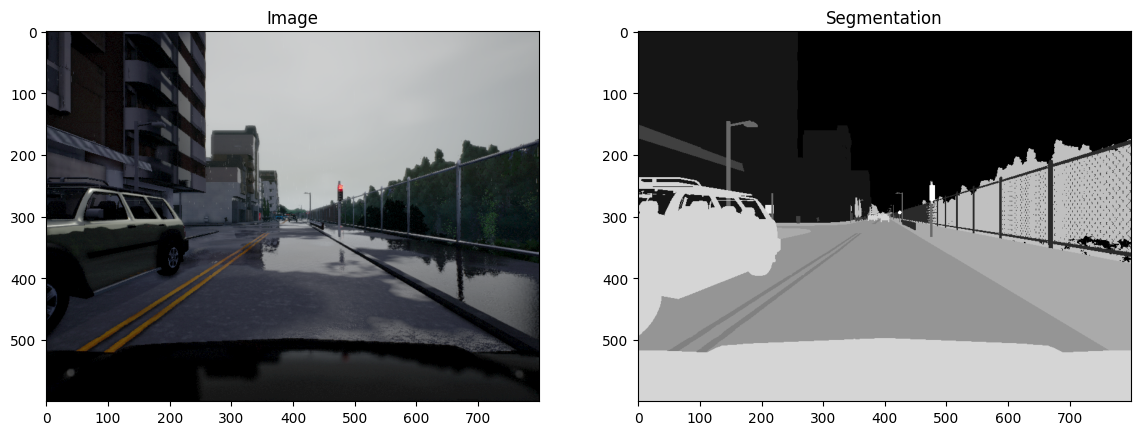

In [8]:
# считываем картинку и ее карту сегментации
img = plt.imread(f'./lyft_segmentation/images/{image_files[0]}')
img_seg = plt.imread(f'./lyft_segmentation/segmentation_masks/{image_files[0]}')

# отрисовываем две картинки рядом друг с другом
_, axes = plt.subplots(1,2, figsize=(14,10))
axes[0].imshow(img);
axes[0].set_title("Image")
axes[1].imshow(img_seg[..., 0], cmap='gray');
axes[1].set_title("Segmentation")

plt.show()

Как видно, на карте сегментации разными градациями серого обозначены разные классы. Давайте посмотрим, сколько всего есть различных классов. Для этого посмотрим, сколько различных значений пикселей есть на картинке:

In [9]:
np.unique(img_seg * 255)  # умножаем на 255, чтобы получить целые числа, а не в градации серого

array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
      dtype=float32)

Как видим, классов сегментации у нас всего 13.

Давайте заведем словарь соответствия классам номерам:

In [10]:
labels = {
    0: 'Unlabeled',
    1: 'Building',
    2: 'Fence',
    3: 'Other',
    4: 'Pedestrian',
    5: 'Pole',
    6: 'Roadline',
    7: 'Road',
    8: 'Sidewalk',
    9: 'Vegetation',
    10: 'Car',
    11: 'Wall',
    12: 'Traffic sign'
}

Давайте для одного изображения отрисуем сегментационную маску для каждого класса по отдельности:

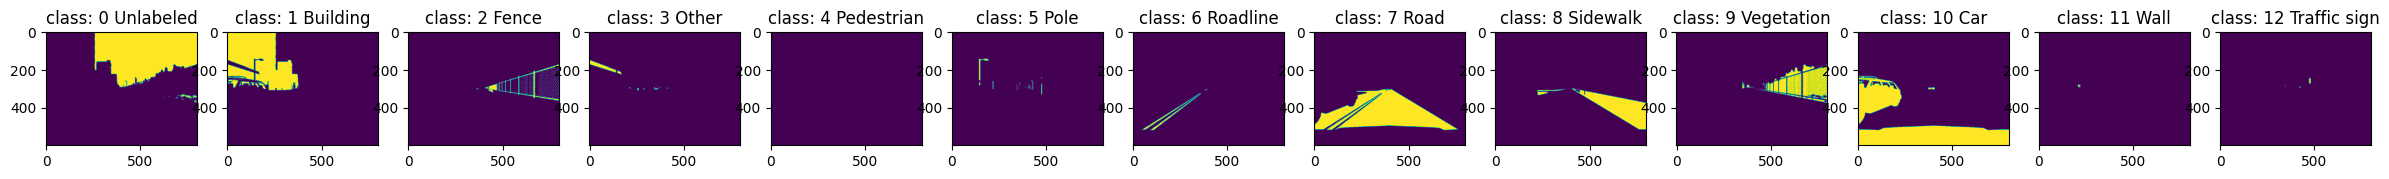

In [11]:
_, axes = plt.subplots(1,13, figsize=(30,5))
for i in range(13):
  mask = plt.imread(f'./lyft_segmentation/segmentation_masks/{image_files[0]}') * 255
  mask = np.where(mask == i, 255, 0)  # где условие выполняется, то есть нужный нам объект, там ставим 255, иначе 0
  mask = mask[:,:,0]  # нулевой канал, потому что изображение черно-белое. там нет других каналов

  axes[i].imshow(mask);
  axes[i].set_title(f'class: {i} {labels[i]}')

### Создадим датасет

Теперь создадим из этих данных датасет для обучения модели.

Для начала создадим два списка:
- список с путями до RGB картинок;
- список с путями до карт сегментаций этих картинок;

In [12]:
images = []
segmentation_masks = []

for img_name in os.listdir('./lyft_segmentation/images/'):
    images.append('./lyft_segmentation/images/' + img_name)

for img_name in os.listdir('./lyft_segmentation/segmentation_masks/'):
    segmentation_masks.append('./lyft_segmentation/segmentation_masks/' + img_name)

In [13]:
images[:5], segmentation_masks[:5]

(['./lyft_segmentation/images/F9-61.png',
  './lyft_segmentation/images/F70-91.png',
  './lyft_segmentation/images/F5-25.png',
  './lyft_segmentation/images/F10-87.png',
  './lyft_segmentation/images/10_00_222.png'],
 ['./lyft_segmentation/segmentation_masks/F9-61.png',
  './lyft_segmentation/segmentation_masks/F70-91.png',
  './lyft_segmentation/segmentation_masks/F5-25.png',
  './lyft_segmentation/segmentation_masks/F10-87.png',
  './lyft_segmentation/segmentation_masks/10_00_222.png'])

Давайте вместо 13 классов остановимся на 4х классах.

Теперь создадим датасет torch.utils.data.Dataset для удобной работы c нашими данными в PyTorch.

In [14]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import v2 as transforms
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Создаем класс для кастомного датасета. Давайте упростим задачу: будем сегментировать картинки только на четыре класса из представленных тринадцати:
- unlabeled;
- building;
- road;
- car.

После занятия вы самостоятельно можете попробовать решить более сложную задачу и сегментировать картинки датасета на большее количество классов.

In [15]:
class SelfDrivingDataset(Dataset):
    def __init__(self, images, segmentation_masks):

        self.images = images
        self.segmentation_masks = segmentation_masks

        self.images_transforms = transforms.Compose([
            transforms.Resize((256, 256)), # размер каждой картинки будет приведен к 256*256
            transforms.ToImage(), # картинка из питоновского массива переводится в формат torch.Tensor
            transforms.ToDtype(torch.float32),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), # значения пикселей картинки нормализуются
        ])

        self.masks_transforms = transforms.Compose([
            # используем InterpolationMode.NEAREST, чтобы при изменении размера
            # маски сегментации не менялись номера классов
            transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST), # размер каждой картинки будет приведен к 256*256
            transforms.ToImage(), # картинка из питоновского массива переводится в формат torch.Tensor
        ])

    def __getitem__(self, index):
        '''
        этот метод должен по заданному номеру пары картинка-сегментация (index)
        возвращать эту пару. Этот метод обязательно нужно реализовывать во всех
        кастомных классах Dataset. Перед тем, как выдать на выходе
        пару картинка-сегментация, можно применить к картинкам любые преобразования:
        например, знакомую нам аугментацию.
        '''

        # загружаем нужные картинку и ее карту сегментации
        img = Image.open(self.images[index])
        mask = Image.open(self.segmentation_masks[index])

        # # применяем предобработку к RGB картинке
        img = self.images_transforms(img)
        # # применяем предобработку к маске сегментации
        mask = self.masks_transforms(mask)


        # # делим маску сегментации на 13 бинарных масок сегментации (теперь 4, тк договрились)
        # # отдельно для каждого класса
        masks = []

        # вытаскиваем пиксели, принадлежащие классам unlabeled, building, road и car.
        for i in [0, 1, 7, 10]:
            # генерируем бинарную маску сегментации для текущего класса i
            cls_mask = torch.where(mask==i, 1, 0)
            masks.append(cls_mask[0,:,:].numpy())

        masks = torch.as_tensor(np.array(masks), dtype=torch.float32)
        # схлопываем бинарные карты сегментации в одну
        masks = torch.argmax(masks, axis=0)

        # возвращаем пару: картинка — ее маска сегментации на 4 класса
        return (img, masks)

    def __len__(self):
        '''
        этот метод должен возвращать количество пар картинка-сегментация в датасете
        '''
        return len(self.images)

Заведем массив классов, на которые мы будем сегментировать картинки. Он пригодится нам ниже, когда мы при обучении сети будем отрисовывать промежуточные результаты сегментации.

In [16]:
labels_used = ['Unlabeled', 'Building', 'Road', 'Car']

Проверим, что наш Dataset работает. Заведем переменную датасета и возьмем нулевой элемент. Отрисуем картинку и одну из ее бинарных карт сегментации.

In [17]:
dataset = SelfDrivingDataset(images, segmentation_masks)

# dataset[0] — это вызов метода __getitem__(0)
img, mask = dataset[3]

print(img.shape, mask.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


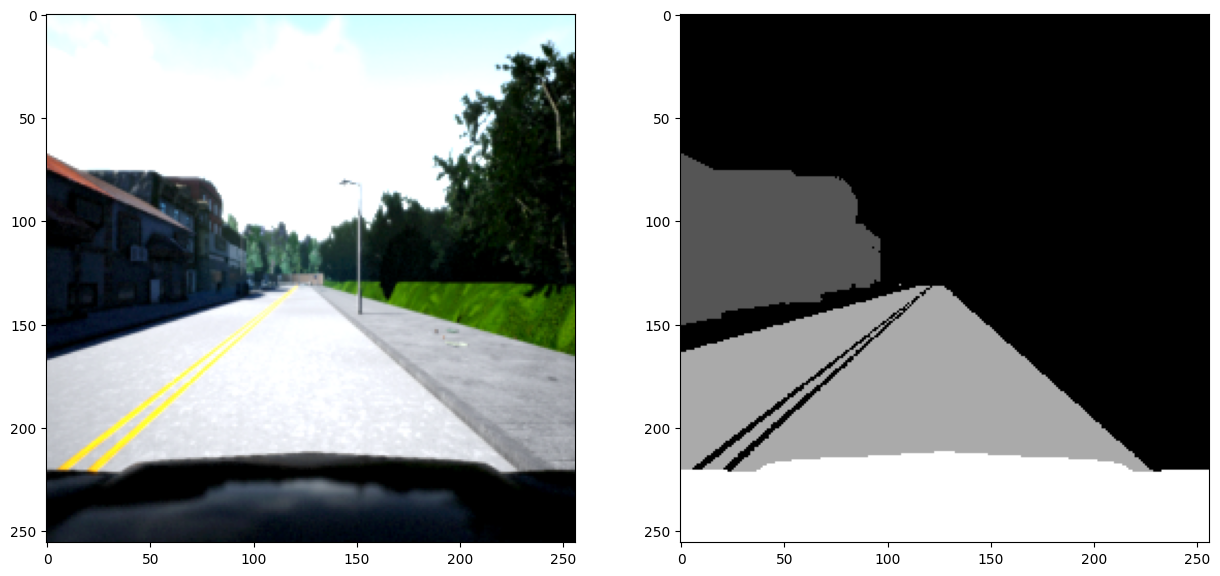

In [18]:
# отрисовываем картинку и ее десятую маску сегментации
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0) / 255)
# показываем бинарную маску 7 класса — "road"
ax[1].imshow(mask, cmap='gray')
plt.show()

In [19]:
mask.unique()

tensor([0, 1, 2, 3])

Разделим выборку на train и val:

In [20]:
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size

train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

И заведем даталоадеры:

In [21]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)

## Metric

### IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

Мы можем сформулировать IoU в терминах матрицы ошибок

Чтобы проверять свои функции на корректность, давайте воспользуемся библиотекой [torchmetrics](https://lightning.ai/docs/torchmetrics/stable/classification/jaccard_index.html)

In [22]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 24.0 MB/s eta 0:00:00


In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [24]:
from torchmetrics import JaccardIndex
import torch
import matplotlib.pyplot as plt
import numpy as np

jaccard = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

In [25]:
def iou_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    # Lets compute metrics for some threshold
    # first convert mask values to probabilities, then
    # apply thresholding

    prob_mask = logits.sigmoid()
    pred_mask = (prob_mask > threshold).float()

    tp = torch.sum(pred_mask*labels)
    fp = torch.sum(pred_mask) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8 # to avoid 0/0
    iou = (tp + eps) / (tp + fp + fn + eps)

    return iou

In [26]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 5.09MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 2.33MB/s]
Download completed


In [27]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

<ipython-input-27-cd9dbfff2c1b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
<ipython-input-

In [28]:
print(dummpy_sample['logits'])
print(dummpy_sample['logits'].sigmoid())
print(dummpy_sample['labels'])

tensor([[[[-1.9818, -3.0264, -3.4634, -3.3669],
          [-3.3132, -3.2690,  0.0526, -3.0650],
          [-3.1722,  0.2558,  0.2902, -3.2031],
          [-3.0457, -3.0761, -3.1206, -3.1873]]]], device='cuda:0')
tensor([[[[0.1211, 0.0462, 0.0304, 0.0333],
          [0.0351, 0.0367, 0.5131, 0.0446],
          [0.0402, 0.5636, 0.5720, 0.0390],
          [0.0454, 0.0441, 0.0423, 0.0396]]]], device='cuda:0')
tensor([[[[0., 0., 0., 0.],
          [0., 1., 1., 0.],
          [0., 1., 0., 0.],
          [0., 0., 0., 0.]]]], device='cuda:0')


In [29]:
print(dummpy_sample['logits'])
print((dummpy_sample['logits'].sigmoid() > 0.5).float())  # маска предикта
print(dummpy_sample['labels'])

tensor([[[[-1.9818, -3.0264, -3.4634, -3.3669],
          [-3.3132, -3.2690,  0.0526, -3.0650],
          [-3.1722,  0.2558,  0.2902, -3.2031],
          [-3.0457, -3.0761, -3.1206, -3.1873]]]], device='cuda:0')
tensor([[[[0., 0., 0., 0.],
          [0., 0., 1., 0.],
          [0., 1., 1., 0.],
          [0., 0., 0., 0.]]]], device='cuda:0')
tensor([[[[0., 0., 0., 0.],
          [0., 1., 1., 0.],
          [0., 1., 0., 0.],
          [0., 0., 0., 0.]]]], device='cuda:0')


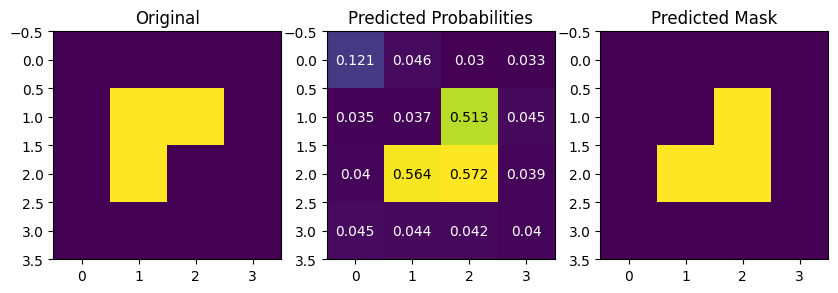

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i, j, round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

In [31]:
iou_ours = iou_score(dummpy_sample['logits'], dummpy_sample['labels'], threshold = 0.5)
iou_torch = jaccard(dummpy_sample['logits'], dummpy_sample['labels'])

In [32]:
assert iou_torch == iou_ours

In [33]:
iou_torch

tensor(0.5000, device='cuda:0')

In [34]:
iou_ours

tensor(0.5000, device='cuda:0')

## Loss

### CrossEntropy Loss

In [35]:
loss = nn.CrossEntropyLoss()

## Model

Здесь мы с вами реализуем модель SegNet.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

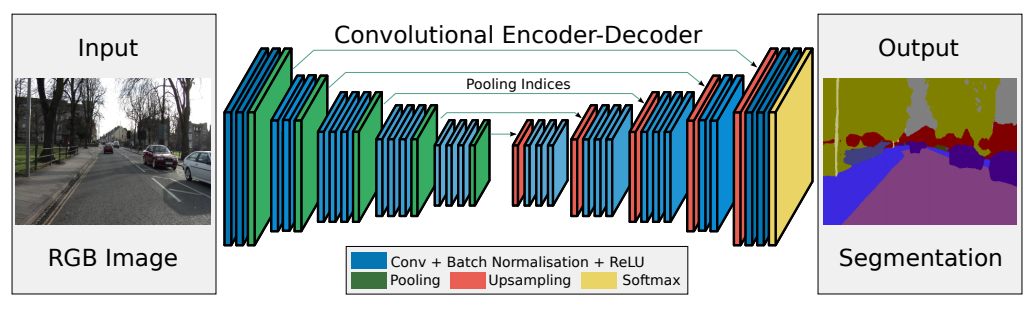

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Давайте разберемся как выглядит архитектура этой модели. Модель SegNet наследует архитектуру VGG16.


To be done:
- Рассмотреть два варианта upsamplig
- Рассмотреть два варианта написания SegNet, просто и через прописание классов EncoderBlock, DecoderBlock
- Посчитать на полном SegNet датасет со всеми 7ю лейблами
- Добавить тестовую выборку

Из статьи:

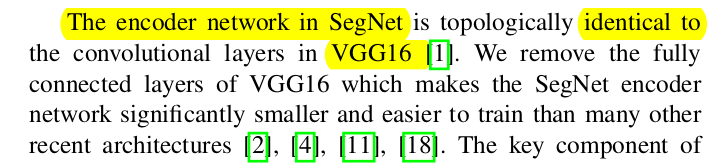

Давайте посмотрим как выглядит архитектура VGG16

In [36]:
import torchvision.models as models

model_ft = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 164MB/s]


In [37]:
model_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
class SegNet_Tiny(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool0 = nn.MaxPool2d((2, 2))  # 256 -> 128
        self.enc_bn0 = nn.BatchNorm2d(num_features=8)
        self.enc_conv1 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d((2, 2)) # 128 -> 64
        self.enc_bn1 = nn.BatchNorm2d(num_features=8)
        self.enc_conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d((2, 2)) # 64 -> 32
        self.enc_bn2 = nn.BatchNorm2d(num_features=16)

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(16, 16, kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_bn0 = nn.BatchNorm2d(num_features=32)
        # слой ConvTranspose2d c такими параметрами не меняет размер
        # карт активаций.
        self.dec_conv0 = nn.ConvTranspose2d(32, 8, 3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_bn1 = nn.BatchNorm2d(num_features=16)
        self.dec_conv1 = nn.ConvTranspose2d(16, 8, 3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_bn2 = nn.BatchNorm2d(num_features=16)
        self.dec_conv2 = nn.ConvTranspose2d(16, 4, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.enc_bn0(self.pool0(F.relu(self.enc_conv0(x))))
        e1 = self.enc_bn1(self.pool1(F.relu(self.enc_conv1(e0))))
        e2 = self.enc_bn2(self.pool2(F.relu(self.enc_conv2(e1))))

        # bottleneck
        b = self.bottleneck_conv(e2)

        # decoder
        d0 = self.dec_conv0(self.dec_bn0(F.relu(self.upsample0(torch.cat([b, e2], 1)))))
        d1 = self.dec_conv1(self.dec_bn1(F.relu(self.upsample1(torch.cat([d0, e1], 1)))))
        d2 = self.dec_conv2(self.dec_bn2(F.relu(self.upsample2(torch.cat([d1, e0], 1)))))

        return d2

## Train

In [39]:
import torch
from torchmetrics import JaccardIndex

from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

In [40]:
def train_single_epoch(model, optimizer, criterion, train_dataloader, device):
    model.train()

    avg_loss = 0
    for X_batch, Y_batch in tqdm(train_dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch) # forward-pass

        loss.backward()  # backward-pass
        optimizer.step()  # update weights
        optimizer.zero_grad() # set parameter gradients to zero

        # calculate loss to show the user
        avg_loss += loss

    avg_loss = avg_loss/len(train_dataloader)

    return model, avg_loss

def validate_single_epoch(model, criterion, valid_dataloader, device, plot=False):

    iou_score = JaccardIndex(threshold=0.5, task="multiclass", num_classes=4, average='none').to(device)
    model.eval()

    avg_loss = 0
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in tqdm(valid_dataloader):
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch)
          iou = iou_score(Y_pred, Y_batch)
          loss = criterion(Y_pred, Y_batch)
          avg_loss += loss
          avg_iou += iou

    avg_loss = avg_loss/len(valid_dataloader)
    avg_iou = avg_iou/len(valid_dataloader)

    if plot:
        clear_output(wait=True)
        our_labels = {
            0: 'Unlabeled',
            1: 'Building',
            2: 'Road',
            3: 'Car',
        }

        fig, axes = plt.subplots(1, 6, figsize=(6*4, 6*4))

        orig_img = X_batch[0].permute(1,2,0).cpu().detach().numpy()
        orig_mask = Y_batch[0].cpu().detach().numpy()

        axes[0].imshow(orig_img);
        axes[0].set_title("Original Image")

        diagram = axes[1].imshow(Y_batch[0].cpu().detach().numpy(), interpolation='none')
        values = np.unique(Y_batch[0].cpu().detach().numpy())
        colors = [ diagram.cmap(diagram.norm(value)) for value in values]
        patches = [ mpatches.Patch(color=colors[i], label=f"{i} - {our_labels[i]}" ) for i in range(len(values)) ]
        axes[1].legend(handles=patches, bbox_to_anchor=(1.00, 1), loc=1, borderaxespad=0. )
        axes[1].set_title("Original Mask")

        for i in range(Y_pred.shape[1]):
            axes[2+i].imshow(Y_pred[0].cpu().detach().numpy()[i]>0.5)
            axes[2+i].set_title(f"{our_labels[i]}, iou = {'%.3f' % avg_iou[i]}")

        plt.show()

    return model, avg_loss, avg_iou

def train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path, plot_loss = False):

    total_train_loss = []
    total_val_loss = []
    total_val_iou = []

    best_val_loss = float('inf')
    best_val_iou = 0

    for epoch in tqdm(range(epochs)):

        model, train_loss = train_single_epoch(model, optimizer, criterion, train_dataloader, device)
        model, val_loss, val_iou = validate_single_epoch(model, criterion, valid_dataloader, device, plot=True)
        print(f'Epoch {epoch}: train loss = {train_loss}')
        print(f'Epoch {epoch}: val loss = {val_loss}')
        print(f'Epoch {epoch}: val iou = {val_iou}')

        total_train_loss.append(train_loss.cpu().detach().numpy())
        total_val_loss.append(val_loss.cpu().detach().numpy())
        total_val_iou.append(val_iou.cpu().detach().numpy())

        if plot_loss:
            fig, (ax1, ax2) = plt.subplots(1, 2)

            ax1.plot(list(range(len(total_train_loss))), total_train_loss, label = 'train loss')
            ax1.plot(list(range(len(total_val_loss))), total_val_loss, label = 'val loss')
            for i in range(len(val_iou)):
              ax2.plot(list(range(len(total_val_iou))), total_val_iou, label = f'val iou: {i}')
            ax1.set_title("Loss")
            ax2.set_title("IoU")
            ax1.legend()
            plt.show()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{ckpt_path}/epoch_{epoch}_best_val_loss.pt')

        torch.save(model.state_dict(), f'{ckpt_path}/epoch_{epoch}_val_iou.pt')

    statistics = {'train loss': total_train_loss,
                  'val_loss': total_val_loss,
                  'val_iou': total_val_iou}

    return model, statistics

def test(model, test_dataloader, device, ckpt_path, ckpt_name):

    model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}')).to(device)
    model.eval()

    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in test_dataloader:
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch.to(device))
          avg_iou += iou_score(X_batch, Y_batch) # , threshold = 0.5)
      avg_iou = avg_iou / len(test_dataloader)

    return avg_iou

In [41]:
model = SegNet_Tiny().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
epochs = 20
ckpt_path = '/content/checkpoints'

In [47]:
import os
os.mkdir(ckpt_path) if not os.path.exists(ckpt_path) else print('Path exists')

Path exists


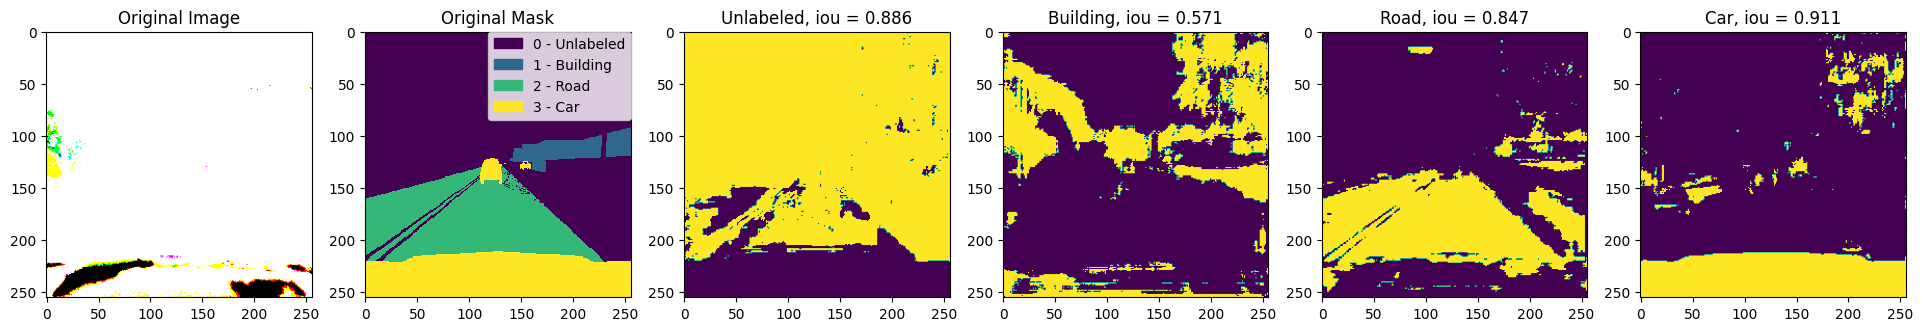

Epoch 19: train loss = 0.1997247040271759
Epoch 19: val loss = 0.21352864801883698
Epoch 19: val iou = tensor([0.8863, 0.5713, 0.8466, 0.9113], device='cuda:0')


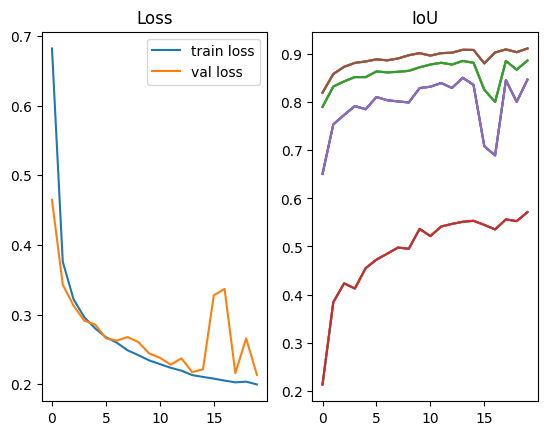

In [48]:
model, statistics = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path, plot_loss = True)

#### Архитектура со skip connection

Можно реализовать архитектуру со skip connection, это представлено ниже

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool0 = nn.MaxPool2d((2, 2))  # 256 -> 128
        self.enc_bn0 = nn.BatchNorm2d(num_features=8)
        self.enc_conv1 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d((2, 2)) # 128 -> 64
        self.enc_bn1 = nn.BatchNorm2d(num_features=8)
        self.enc_conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d((2, 2)) # 64 -> 32
        self.enc_bn2 = nn.BatchNorm2d(num_features=16)

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(16, 16, kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_bn0 = nn.BatchNorm2d(num_features=32)
        # слой ConvTranspose2d c такими параметрами не меняет размер
        # карт активаций. 
        self.dec_conv0 = nn.ConvTranspose2d(32, 8, 3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_bn1 = nn.BatchNorm2d(num_features=16)
        self.dec_conv1 = nn.ConvTranspose2d(16, 8, 3, padding=1) 
        self.upsample2 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_bn2 = nn.BatchNorm2d(num_features=16)
        self.dec_conv2 = nn.ConvTranspose2d(16, 4, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.enc_bn0(self.pool0(F.relu(self.enc_conv0(x))))
        e1 = self.enc_bn1(self.pool1(F.relu(self.enc_conv1(e0))))
        e2 = self.enc_bn2(self.pool2(F.relu(self.enc_conv2(e1))))

        # bottleneck
        b = self.bottleneck_conv(e2)

        # decoder
        d0 = self.dec_conv0(self.dec_bn0(F.relu(self.upsample0(torch.cat([b, e2], 1)))))
        d1 = self.dec_conv1(self.dec_bn1(F.relu(self.upsample1(torch.cat([d0, e1], 1)))))
        d2 = self.dec_conv2(self.dec_bn2(F.relu(self.upsample2(torch.cat([d1, e0], 1)))))
        
        return d2